In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os 
import time
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import re
import random
import nltk.data
import seaborn as sns
from textblob import TextBlob
import scipy.stats as stats


# Big Picture Descriptives

In [2]:
# get all folders in a directory
f_1 = 'simg-b1734-s2023-03-17/'
folders = os.listdir(f_1)
df = pd.read_csv(f_1 + folders[0] + '/' + [i for i in os.listdir(f_1+ folders[0]) if i.endswith('.csv')][0])
for f_2 in folders[1:]:
    if (f_2 == '.DS_Store') | (f_2 == 'README.md') | (f_2 == 'search_records'):
        continue
    else:
        file = [i for i in os.listdir(f_1+ f_2) if i.endswith('.csv')][0]
        df_temp = pd.read_csv(f_1+ f_2 + '/' + file)
        df = pd.concat([df, df_temp], axis=0)
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Month'] = df['Month'].astype(str) + '-' + df['Year'].astype(str)
df['Month'] = pd.to_datetime(df['Month'], format='%M-%Y')
df = df.loc[df.Date < '2023-01-01']

# Some of the publications have different spellings, so we can use the replace method to replace the mispelled names with the correct names

# Recode items in the Publication column to group together different spellings
df['Publication'] = df['Publication'].replace('Philadelphia Daily News', 'The Philadelphia Daily News') #'The Philadelphia Daily News', 'Philadelphia Daily News'
df['Publication'] = df['Publication'].replace('Pittsburgh Post-Gazette (Pennsylvania)','Pittsburgh Post-Gazette') # 'Pittsburgh Post-Gazette', 'Pittsburgh Post-Gazette (Pennsylvania)'
df['Publication'] = df['Publication'].replace('Journal of Commerce - JoC Online','Journal of Commerce') # 'Journal of Commerce Online', 'Journal of Commerce', 'Journal of Commerce - JoC Online'
df['Publication'] = df['Publication'].replace('Journal of Commerce Online','Journal of Commerce')
# Should we recode, or exclude the NYT blogs?
df['Publication'] = df['Publication'].replace('The New York Times Blogs  (Bits)','The New York Times') #'The New York Times','The New York Times Blogs  (Bits)','The New York Times Blogs  (Opinionator)','The New York Times  (Lens)','The New York Times Blogs  (Motherlode)','The New York Times Blogs  (Wordplay)',
df['Publication'] = df['Publication'].replace('The New York Times Blogs  (Opinionator)','The New York Times')
df['Publication'] = df['Publication'].replace('The New York Times  (Lens)','The New York Times')
df['Publication'] = df['Publication'].replace('The New York Times Blogs  (Motherlode)','The New York Times')
df['Publication'] = df['Publication'].replace('The New York Times Blogs  (News)','The New York Times')
df['Publication'] = df['Publication'].replace('The New York Times Blogs  (Wordplay)','The New York Times')
df['Publication'] = df['Publication'].replace('The New York Times Blogs  (DealBook)','The New York Times')
df['Publication'] = df['Publication'].replace("The New York Times Blogs  (You're the Boss)",'The New York Times')
df['Publication'] = df['Publication'].replace('The New York Times Blogs  (City Room)','The New York Times')
df['Publication'] = df['Publication'].replace('The New York Times Blogs  (Op-Talk)','The New York Times')
df['Publication'] = df['Publication'].replace('The New York Times Blogs  (Paul Krugman)','The New York Times')
df['Publication'] = df['Publication'].replace('The New York Times Blogs  (ArtsBeat)','The New York Times')
df['Publication'] = df['Publication'].replace('The New York Times Blogs  (The Learning Network)','The New York Times')
df['Publication'] = df['Publication'].replace('The New York Times Blogs  (Sinosphere)','The New York Times')
df['Publication'] = df['Publication'].replace('The New York Times Blogs  (Times Insider)','The New York Times')
df['Publication'] = df['Publication'].replace('The New York Times Blogs  (T Magazine)','The New York Times')
df['Publication'] = df['Publication'].replace('The New York Times Blogs  (Paul Krugman)','The New York Times')
df['Publication'] = df['Publication'].replace('The New York Times  (Paul Krugman)','The New York Times')

df['Publication'] = df['Publication'].replace('The Tampa Tribune (Florida)', 'Tampa Tribune (Florida)') #'The Tampa Tribune (Florida)', 'Tampa Tribune (Florida)',
df['Publication'] = df['Publication'].replace('The Atlanta Journal-Constitution', 'The Atlanta Journal and Constitution') #'The Atlanta Journal-Constitution', 'The Atlanta Journal and Constitution'
df['Publication'] = df['Publication'].replace('Christian Science Monitor (Boston, MA)','Christian Science Monitor')
df['Publication'] = df['Publication'].replace('The Christian Science Monitor','Christian Science Monitor')#'The Christian Science Monitor',  'Christian Science Monitor','Christian Science Monitor (Boston, MA)'

df['Publication'] = df['Publication'].replace('USA TODAY NOW','USA TODAY') #'USA Today Now', 'USA Today' #'USA Today Now', 'USA Today'
df['Publication'] = df['Publication'].replace('USA Today','USA TODAY')
df['Publication'] = df['Publication'].replace('The Philadelphia Inquirer','Philadelphia Inquirer') #'USA Today Now', 'USA Today'

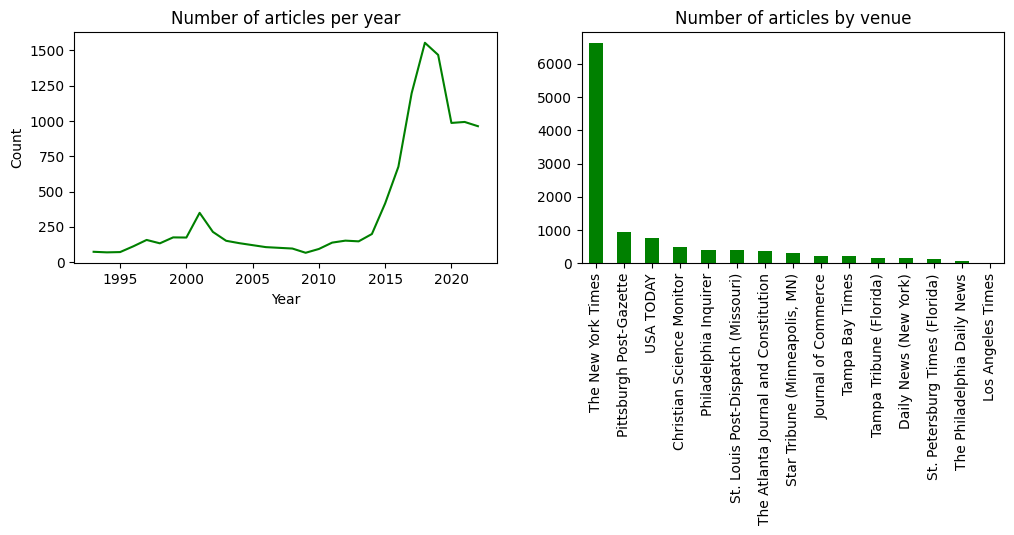

In [3]:

# plot the number of articles per year
# Make the fig size 6 by 3
fig, ax = plt.subplots(1,2,figsize=(12,3))

df.groupby('Year').count()['Title'].plot(kind='line',ax=ax[0],color='green')
ax[0].set_title('Number of articles per year')
ax[0].set_ylabel('Count')

df.groupby('Publication').count()['Title'].sort_values(ascending=False).plot(kind='bar',ax=ax[1],color='green')
ax[1].set_title('Number of articles by venue')
ax[1].set_xlabel('')
plt.show()

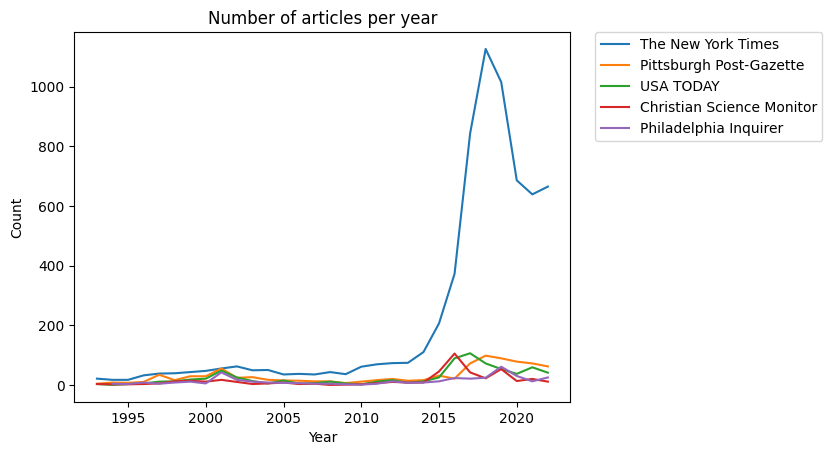

In [4]:
for p in df.groupby('Publication').count()['Title'].sort_values(ascending=False).index[:5]:
    df_temp = df.loc[df.Publication == p]
    df_temp.groupby('Year').count()['Title'].plot(kind='line', label=p)

plt.title('Number of articles per year')
plt.ylabel('Count')
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.show()

# Get all sentences that mention AI along with the sentence before and after them

In [8]:
# split the paragraph into sentences by splitting all punctuation Add the punctuation back to the end of each sentence

def split_sentences(paragraph):
    sentences = re.split('([.!?])', paragraph)
    # remove the empty strings
    sentences = [x for x in sentences if x != '']
    # Add the punctuation back to the end of each sentence
    sentences = [x + y for x, y in zip(sentences[0::2], sentences[1::2])]
    return sentences

paragraph = 'Sentence 1. Sentence 2! Sentence 3 word? Sentence 4.'
sentences = split_sentences(paragraph)
print(sentences)


# Iterate through the files in each of the folders
def get_mentions(words):
    file_name, n_words, sentence_before, sentence_of, sentence_after = [], [], [] ,[], []
    tokenizer = nltk.data.load('nltk:tokenizers/punkt/english.pickle')
    for f_2 in folders:
        if (f_2 == '.DS_Store') | (f_2 == 'README.md') | (f_2 == 'search_records'):
            continue
        else:
            for f_3 in os.listdir(f_1 + f_2 +'/plaintext/'):
                with open(f_1 + f_2 + '/plaintext/' + f_3,'r') as f:

                    # Split the text into each different sentence
                    contents = f.read()
                    #all_sentences = split_sentences(contents) # Calvin's method which just uses punctuation
                    all_sentences = tokenizer.tokenize(contents) # NLTK's method which uses punctuation and new lines


                    # For every search word, identify the sentences that it is in
                    sentence_locs = []
                    for word in words:
                        sentence_locs = sentence_locs + [i for i, x in enumerate(all_sentences) if re.search(word, x, re.IGNORECASE)]

                    # For each sentence that the search word is in, get the sentence before, the sentence of, and the sentence after
                    for i in set(sentence_locs):
                        if len(all_sentences) < 2:
                            continue
                        else:
                            if i == 0:
                                sentence_before.append("")
                                sentence_of.append(all_sentences[i])
                                sentence_after.append(all_sentences[i+1])
                            elif i == len(all_sentences)-1:
                                sentence_before.append(all_sentences[i-1])
                                sentence_of.append(all_sentences[i])
                                sentence_after.append('')
                            else:
                                sentence_before.append(all_sentences[i-1])
                                sentence_of.append(all_sentences[i])
                                sentence_after.append(all_sentences[i+1])
                            file_name.append(f_3)
                            n_words.append(len(contents.split()))
    
    # Return the results as a dataframe
    print('length of file_name: ', len(file_name), 'length of n_words: ', len(n_words), 'length of sentence_before: ', len(sentence_before), 'length of sentnce_of: ', len(sentence_of), 'length of sentence_after: ', len(sentence_after))
    return pd.DataFrame({'Filename':file_name, 'n_words':n_words, 'sentence_before':sentence_before, 'sentnce_of':sentence_of, 'sentence_after':sentence_after})
df_references = get_mentions(['artificial intelligence',' AI ','machine learning'])

['Sentence 1.', ' Sentence 2!', ' Sentence 3 word?', ' Sentence 4.']
length of file_name:  19141 length of n_words:  19141 length of sentence_before:  19141 length of sentnce_of:  19141 length of sentence_after:  19141


In [11]:
# For every row in df_reference, combine the sentence before, the sentence of, and the sentence after then perform a sentiment analysis on the combined sentence
sid = SentimentIntensityAnalyzer()
def get_sentiment(row):
    sentence = row['sentence_before'] + row['sentnce_of'] + row['sentence_after']
    ss = sid.polarity_scores(sentence)
    return ss['compound']

df_references['sentiment'] = df_references.apply(get_sentiment, axis=1)
# get a random sample of 5 rows from the dataframe
# for every row in the sample print sentiment followed by the three sentences concatenated:
for index, row in df_references.sample(5).iterrows():
    print(index,row['sentiment'], row['sentence_before'] +" " + row['sentnce_of'] + " " + row['sentence_after'])

def get_sentiment(row):
    sentence = row['sentence_before'] + row['sentnce_of'] + row['sentence_after']
    return TextBlob(sentence).sentiment.polarity

df_references['sentiment_2'] = df_references.apply(get_sentiment, axis=1)

print(stats.pearsonr(df_references['sentiment'], df_references['sentiment_2']))

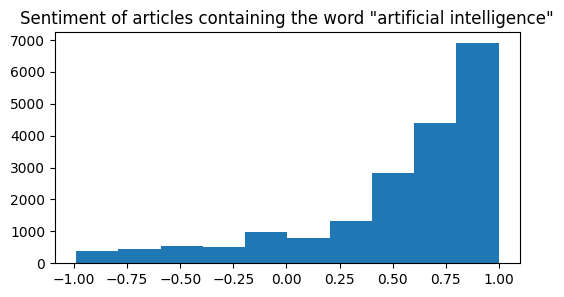

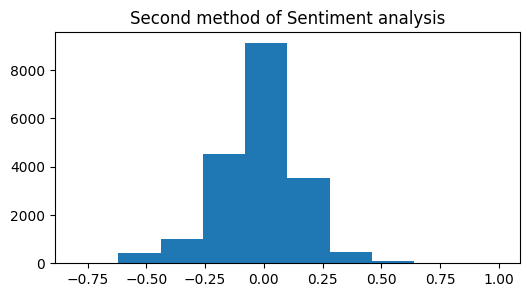

In [70]:

# turn off the grid
fig, ax = plt.subplots(1,1,figsize=(6,3))
df_references.sentiment.hist(ax=ax)
ax.grid(False)
ax.set_title('Sentiment of articles containing the word "artificial intelligence"')
plt.show()



# turn off the grid
fig, ax = plt.subplots(1,1,figsize=(6,3))
df_references.sentiment_2.hist(ax=ax)
ax.grid(False)
ax.set_title('Second method of Sentiment analysis')
plt.show()

df_references['differences'] = df_references['sentiment'] * df_references['sentiment_2']

In [78]:
# Get differences below -0.5
for index, row in df_references.loc[df_references.differences < -0.5].sample(5).iterrows():
    print(index,row['sentiment'],row['sentiment_2'], row['sentence_before'] +" " + row['sentnce_of'] + " " + row['sentence_after'])

13399 0.8779 -0.6 So for those deciding between the two products, I recommend waiting to see if Home expands its abilities before making a purchase. Pop Quiz

All virtual assistants, which are backed by artificial intelligence, are , including Google’s Assistant, Apple’s Siri, Amazon’s Alexa and Microsoft’s Cortana. But Google’s Assistant is smarter than Alexa.
15196 0.9042 -0.6 "We hire people who have a heart for this work, and that can't be faked," Burnight said. "No amount of artificial intelligence will ever make the connections and offer the empathy of a human. No robot can come up with compassionate solutions.
4921 0.8555 -0.6 save us from faked videos? Google and Facebook are running contests for researchers to build artificial intelligence systems that can detect videos doctored with cutting-edge artificial intelligence, known as deepfakes. The contests are showing .
8078 0.8402 -0.6 They are meant to force tech firms to aggressively remove unlicensed copyrighted material from

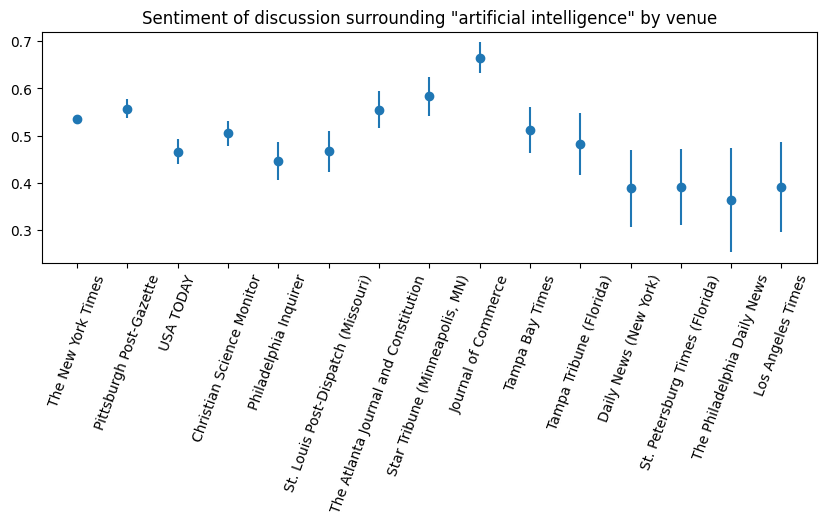

In [73]:
df_plot_venue = df_references.merge(df, on='Filename')#.groupby('Publication').mean()['sentiment'].sort_values(ascending=False).plot(kind='bar',color='green')

# plot the mean sentiment by venue with 95% confidence intervals
fig, ax = plt.subplots(1,1,figsize=(10,3))
# plot the mean sentiment by venue with 95% confidence intervals in descending order by count of articles

M = df_plot_venue.groupby('Publication').mean()['sentiment'].loc[df.groupby('Publication').count()['Title'].sort_values(ascending=False).index]
N = df_plot_venue.groupby('Publication').count()['sentiment'].loc[df.groupby('Publication').count()['Title'].sort_values(ascending=False).index]
SDS = df_plot_venue.groupby('Publication').std()['sentiment'].loc[df.groupby('Publication').count()['Title'].sort_values(ascending=False).index]

ax.errorbar(range(15),M.values, yerr=1.96*SDS.values/np.sqrt(N.values), fmt='o')

ax.set_title('Sentiment of discussion surrounding "artificial intelligence" by venue')
ax.set_xlabel('')
ax.set_xticks(range(15))
ax.set_xticklabels(list(df_plot_venue.groupby('Publication').std()['sentiment'].loc[df.groupby('Publication').count()['Title'].sort_values(ascending=False).index].index),rotation=70)
plt.show()

#plt.title('Sentiment of articles containing the word "artificial intelligence" by venue')
#plt.xlabel('')
#plt.show()

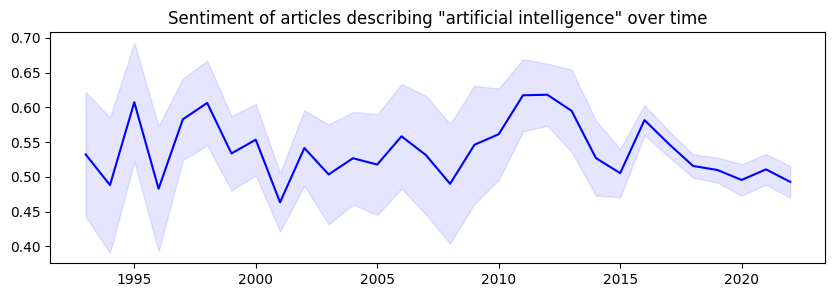

In [75]:
# plot the average sentiment over time in a line plot with 95% confidence intervals

df_plot_time = df_references.merge(df, on='Filename')
fig, ax = plt.subplots(1,1,figsize=(10,3))
df_plot_time['Date'] = pd.to_datetime(df_plot_time['Date'])

xs = df_plot_time.groupby('Year').mean()['sentiment'].index
means = df_plot_time.groupby('Year').mean()['sentiment'].values
ci_amount = 1.96*df_plot_time.groupby('Year').std()['sentiment'].values/np.sqrt(df_plot_time.groupby('Year').count()['sentiment'].values)
ax.plot(xs,means, color='blue')
ax.fill_between(xs, [means[i] - ci_amount[i] for i in range(len(means))],[means[i] + ci_amount[i] for i in range(len(means))], color='blue', alpha=.1)

plt.title('Sentiment of articles describing "artificial intelligence" over time')
plt.xlabel('')
plt.show()


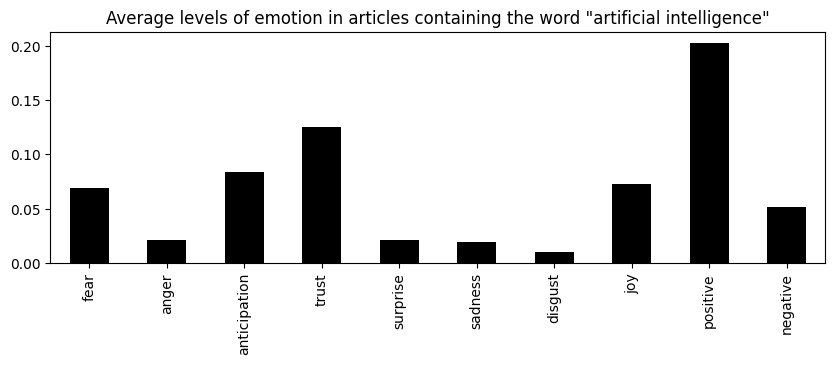

In [94]:
# Download the NRC Emotion Lexicon
from nrclex import NRCLex

def get_emotions(row):
    sentence = row['sentence_before'] + row['sentnce_of'] + row['sentence_after']
    try:
        emotion = NRCLex(sentence).affect_frequencies
        return emotion['fear'], emotion['anger'], emotion['anticipation'], emotion['trust'], emotion['surprise'], emotion['sadness'], emotion['disgust'], emotion['joy'], emotion['positive'], emotion['negative']
    except:
        return 0,0,0,0,0,0,0,0,0,0
df_references['fear'], df_references['anger'], df_references['anticipation'], df_references['trust'], df_references['surprise'], df_references['sadness'], df_references['disgust'], df_references['joy'], df_references['positive'], df_references['negative'] = zip(*df_references.apply(get_emotions, axis=1))


# Create a plot with average levels of each emotion overall, add pretty colors
fig, ax = plt.subplots(1,1,figsize=(10,3))
df_references[['fear', 'anger', 'anticipation', 'trust', 'surprise', 'sadness', 'disgust', 'joy', 'positive', 'negative']].mean().plot(kind='bar', ax=ax, color=['#000000','#000000','#000000','#000000','#000000','#000000','#000000','#000000','#000000','#000000'])
ax.set_title('Average levels of emotion in articles containing the word "artificial intelligence"')
plt.show()


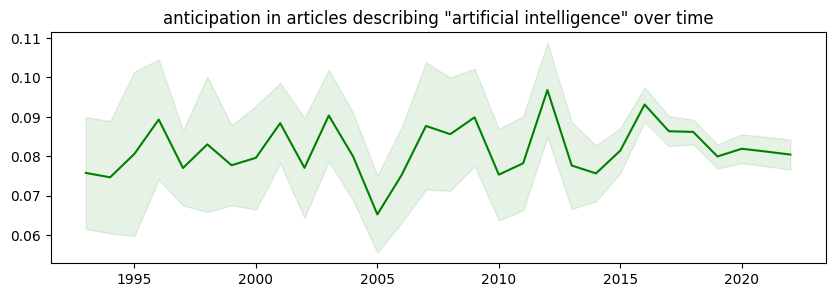

In [101]:
emotion = 'anticipation'
color = 'green'
df_plot_time = df_references.merge(df, on='Filename')
fig, ax = plt.subplots(1,1,figsize=(10,3))
df_plot_time['Date'] = pd.to_datetime(df_plot_time['Date'])

xs = df_plot_time.groupby('Year').mean()[emotion].index
means = df_plot_time.groupby('Year').mean()[emotion].values
ci_amount = 1.96*df_plot_time.groupby('Year').std()[emotion].values/np.sqrt(df_plot_time.groupby('Year').count()[emotion].values)
ax.plot(xs,means, color=color)
ax.fill_between(xs, [means[i] - ci_amount[i] for i in range(len(means))],[means[i] + ci_amount[i] for i in range(len(means))], color=color, alpha=.1)

plt.title(emotion+' in articles describing "artificial intelligence" over time')
plt.xlabel('')
plt.show()


In [104]:
health_words = ['health','medicine','medical','hospital','doctor','nurse','diagnosis','prescription']
justice_words = ['justice','law','court','judge','attorney','lawyer','jury','trial','freedom']
education_words = ['education','school','student','teacher','lesson','teach']

# For every word, look to see if it's in the row. If it is return a 1, if not return a 0. ignore case

def other_topics(row,words):
    sentence = row['sentence_before'] + row['sentnce_of'] + row['sentence_after']
    for word in words:
        if word in sentence.lower():
            return 1
    return 0

df_references['health'] = df_references.apply(other_topics, axis=1, args=(health_words,))
df_references['justice'] = df_references.apply(other_topics, axis=1, args=(justice_words,))
df_references['education'] = df_references.apply(other_topics, axis=1, args=(education_words,))

print(df_references.health.count())
print('N Health =',df_references.loc[df_references.health == 1].health.count(),'N Justice =',df_references.loc[df_references.justice == 1].justice.count(),'N Education =',df_references.loc[df_references.education == 1].education.count())

# Concatenate the sentences before and after the reference to get a full sentence
list(df_references.loc[df_references.education == 1].iloc[2,2:5].values)

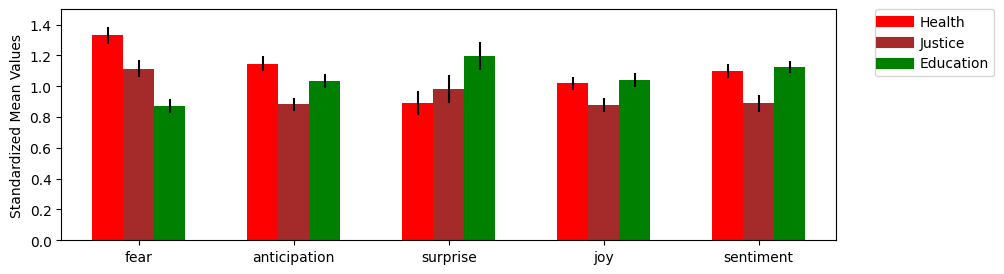

In [129]:
# create a bar plot showiing average fear, anticipation, surprise, joy, sentiment by topic along with 95% confidence intervals


fig, ax = plt.subplots(1,1,figsize=(10,3))
m = 0
for col in ['fear', 'anticipation', 'surprise', 'joy', 'sentiment']:
    ax.bar([m-0.2,m,m+0.2],[i / df_references[col].mean() for i in [df_references.loc[df_references.health == 1][col].mean(),
            df_references.loc[df_references.justice == 1][col].mean(),
            df_references.loc[df_references.education == 1][col].mean()]],
              yerr=[i / df_references[col].mean() for i in [1.96*df_references.loc[df_references.health == 1][col].std()/np.sqrt(df_references.loc[df_references.health == 1][col].count()),
                    1.96*df_references.loc[df_references.justice == 1][col].std()/np.sqrt(df_references.loc[df_references.justice == 1][col].count()),
                    1.96*df_references.loc[df_references.education == 1][col].std()/np.sqrt(df_references.loc[df_references.education == 1][col].count())]],
                color=['red','brown','green'], width=0.2)
    m += 1
ax.plot(100,100, color='red', label='Health', linewidth=8)
ax.plot(100,100, color='brown', label='Justice', linewidth=8)
ax.plot(100,100, color='green', label='Education', linewidth=8)
ax.set_xlim(-0.5,4.5)
ax.set_ylim(0,1.5)
ax.set_xticks([0,1,2,3,4])
ax.set_ylabel('Standardized Mean Values')
ax.set_xticklabels(['fear','anticipation','surprise','joy','sentiment'])

# Put the legend out of the figure
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

# Get random set of 100

In [ ]:
file_names, texts = [], []
for f_2 in folders:
    if (f_2 == '.DS_Store') | (f_2 == 'README.md') | (f_2 == 'search_records'):
        continue
    else:
        for f_3 in os.listdir(f_1 + f_2 +'/plaintext/'):
            all_references = []
            with open(f_1 + f_2 + '/plaintext/' + f_3,'r') as f:
                contents = f.read()
                file_names.append(f_3)
                texts.append(contents)
df_text = pd.DataFrame({'Filename':file_names, 'Text':texts})

df_titles = df[['Filename','Title']].merge(df_text, on='Filename', how='left')

# get a random sample of 100 articles
df_sample = df_titles.sample(100)

df_sample['Coder'] =  ["Sim" for i in range(33)] + ["Ben" for i in range(33)] + ["Calvin" for i in range(34)]
df_sample.to_excel('100_articles.xlsx')

# OLD -  Time to start analyzing some text

In [ ]:
ai = ['artificial intelligence']

file_name, n_words, text = [], [], []  

# Iterate through the files in each of the folders
def get_mentions(words):
    for f_2 in folders:
        if (f_2 == '.DS_Store') | (f_2 == 'README.md') | (f_2 == 'search_records'):
            continue
        else:
            for f_3 in os.listdir(f_1 + f_2 +'/plaintext/'):
                all_references = []
                with open(f_1 + f_2 + '/plaintext/' + f_3,'r') as f:

                    contents = f.read()

                    for word in words:
                        if word == 'AI':
                            locs = [m.start() for m in re.finditer(word, contents)]
                        else:
                            locs = [m.start() for m in re.finditer(word, contents,re.IGNORECASE)]
                        # collect the text surrounding the keywords
                        for i in locs:
                            if i < 70:
                                all_references.append(contents[:i+70])
                            elif i > len(contents)-70:
                                all_references.append(contents[i-70:])
                            else:
                                all_references.append(contents[i-70:i+70])
                file_name.append(f_3)
                n_words.append(len(contents.split()))
                text.append(all_references)
    return pd.DataFrame({'Filename':file_name, 'n_words':n_words, 'text':text})           



In [ ]:
# Keywords related to healthcare:
ai = ['artificial intelligence','machine learning']
health_words = ['health','medicine','medical','hospital','doctor','nurse','diagnosis','prescription']
justice_words = ['justice','law','court','judge','attorney','lawyer','jury','trial','freedom']
education_words = ['education','school','student','teacher','lesson','teach']

df_references = get_mentions(ai)


In [ ]:
df_references.loc[df_references.text.str.len() > 0]

,Filename,n_words,text
0,pittsburgh-post-gazette-(pennsylvania)-we_re-f...,1278,[dened to include students who specialize in s...
1,pittsburgh-post-gazette-(pennsylvania)-the-con...,608,[]
2,pittsburgh-post-gazette-(pennsylvania)-machine...,726,[]
3,pittsburgh-post-gazette-(pennsylvania)-in-arct...,689,[]
4,pittsburgh-post-gazette-tool-adds-ai-b8f9ceac-...,489,[Kumar and Jaime Carbonell of Talencea () have...
...,...,...,...
9220,los-angeles-times-business-chatgpt-risks-b1ad9...,751,[]
9221,los-angeles-times-letters-b213daa6-af5b-11ed-a...,785,[ed as classroom teachers who assign and grade...
9222,los-angeles-times-letters-_clarion-call-b1bf89...,1111,[]
9223,los-angeles-times-the-big-gop-b1d41a24-af5b-11...,849,[]


In [ ]:
df_references = df_references.loc[df_references.text.apply(lambda x: len(x)) > 0] # returns an individual instance of the text

In [ ]:
sent_get = SentimentIntensityAnalyzer()
def get_vaders(lot):
    if len(lot) == 0:
        return None
    else:
        return [sent_get.polarity_scores(i)['compound'] for i in lot]

In [ ]:
df_references['vader'] = df_references.text.apply(get_vaders)
df_references['avg_vader'] = df_references.vader.apply(lambda x: np.mean(x) if x is not None else None)
df_references.drop_duplicates(subset=['Filename'],inplace=True)
df = df.merge(df_references[['Filename','avg_vader']],on='Filename',how='left')

In [ ]:
# plot the average vader score by year with 95% confidence intervals
df_1 = df.dropna(subset =['avg_vader'])
df_1

,Filename,Publication,Section,Date,Title,Author,LNID,Year,avg_vader_x,avg_vader_y,avg_vader
1,the-philadelphia-daily-news-letters_-pennsylva...,The Philadelphia Daily News,EDITORIAL OPINION,2010-11-22,Letters: Pennsylvania Supreme Court Chief Just...,NaN,51HT-P8Y1-DYJT-23V3-00000-00,2010.0,NaN,0.0000,0.0000
2,the-philadelphia-daily-news-tattle_-katy-perry...,The Philadelphia Daily News,FEATURES,2012-08-28,Tattle: Katy Perry turns down a reported $20...,By Howard Gensler,56FB-R5D1-JC3R-B3RG-00000-00,2012.0,NaN,0.0000,0.0000
8,the-philadelphia-daily-news-high-schools---664...,The Philadelphia Daily News,SPORTS,2009-03-24,High Schools - Nasir Jones stellar in Public L...,By TED SILARY,7V96-1FF0-Y9F1-X3HH-00000-00,2009.0,0.8591,0.8591,0.8591
13,the-philadelphia-daily-news-the-shape-of-6653a...,The Philadelphia Daily News,FEATURES,2009-12-28,"The shape of slots to come: Think HD, big scre...",By CHUCK DARROW,7XDP-20M1-2R00-600V-00000-00,2009.0,0.7089,0.7089,0.7089
15,the-philadelphia-daily-news-letters_-solution-...,The Philadelphia Daily News,EDITORIAL OPINION,2009-11-24,Letters: Solution for Port Richmond abuses,NaN,7X5F-1T30-Y9F1-X4G9-00000-00,2009.0,NaN,0.8176,0.8176
...,...,...,...,...,...,...,...,...,...,...,...
13816,the-atlanta-journal-constitution-guest-column-...,The Atlanta Journal and Constitution,NEWS,2020-12-06,GUEST COLUMN How virus points way to faster fu...,Llewellyn King,61FT-C3J1-JC85-V01C-00000-00,2020.0,0.8126,0.8126,0.8126
13817,the-atlanta-journal-constitution-ajc-exclusive...,The Atlanta Journal and Constitution,METRO,2018-04-02,AJC EXCLUSIVE STARTUPS Goldman Sachs joins fun...,J. Scott Trubey,5S11-5BM1-DYR7-J008-00000-00,2018.0,0.8020,0.8020,0.8020
13818,the-atlanta-journal-constitution-only-in-the-3...,The Atlanta Journal and Constitution,NEWS,2019-01-21,"ONLY IN THE AJC KING DAY On MLK's birthday, fr...",Ernie Suggs and Rosalind Bentley,5V7P-RX91-JC85-V42R-00000-00,2019.0,NaN,0.6369,0.6369
13819,the-atlanta-journal-constitution-ajc-exclusive...,The Atlanta Journal and Constitution,METRO,2020-01-28,"AJC EXCLUSIVE In an uncertain world, let kids ...",Maureen Downey Only in the AJC,5Y31-X8V1-JC85-V194-00000-00,2020.0,0.6070,0.6070,0.6070


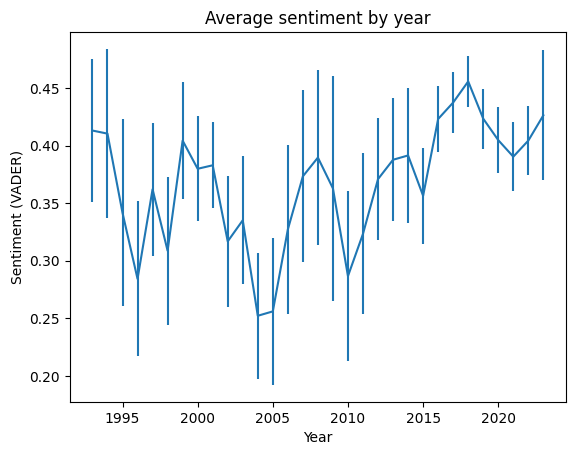

In [ ]:
# Plot the average vader score by year
df.groupby('Year').mean()['avg_vader'].plot(kind='line',yerr=df.groupby('Year').std()['avg_vader']*1.96/np.sqrt(df.groupby('Year').count()['avg_vader']))
plt.title('Average sentiment by year')
plt.ylabel('Sentiment (VADER)')
plt.show()

In [ ]:
# We can use statistical techniques to identify emergent keywords
# import the necessary packages
import yake
import re

kw_extractor = yake.KeywordExtractor()
keywords = kw_extractor.extract_keywords(contents)
# identify keywords in text

,Filename,Publication,Section,Date,Title,Author,LNID,Year
0,the-philadelphia-daily-news-drexel-will-run-66...,The Philadelphia Daily News,SPORTS,2009-12-21,Drexel will run into Kentucky's Wall,By MIKE MAZZEO,7XC6-7S11-2R00-6367-00000-00,2009.0
1,the-philadelphia-daily-news-letters_-pennsylva...,The Philadelphia Daily News,EDITORIAL OPINION,2010-11-22,Letters: Pennsylvania Supreme Court Chief Just...,NaN,51HT-P8Y1-DYJT-23V3-00000-00,2010.0
2,the-philadelphia-daily-news-tattle_-katy-perry...,The Philadelphia Daily News,FEATURES,2012-08-28,Tattle: Katy Perry turns down a reported $20...,By Howard Gensler,56FB-R5D1-JC3R-B3RG-00000-00,2012.0
3,the-philadelphia-daily-news-publics-go-to-6645...,The Philadelphia Daily News,WEB,2012-05-11,Publics go to town in Eagles City All-Star Foo...,BY TED SILARY,55M3-X631-DYJT-221T-00000-00,2012.0
4,the-philadelphia-daily-news-director-alison-kl...,The Philadelphia Daily News,ENTERTAINMENT,2012-08-10,Director Alison Klayman profiles Chinese activ...,By Molly EichelDaily News Staff Writer,569H-7WT1-DYJT-2041-00000-00,2012.0
...,...,...,...,...,...,...,...,...
165,the-atlanta-journal-constitution-guest-column-...,The Atlanta Journal and Constitution,NEWS,2020-12-06,GUEST COLUMN How virus points way to faster fu...,Llewellyn King,61FT-C3J1-JC85-V01C-00000-00,2020.0
166,the-atlanta-journal-constitution-ajc-exclusive...,The Atlanta Journal and Constitution,METRO,2018-04-02,AJC EXCLUSIVE STARTUPS Goldman Sachs joins fun...,J. Scott Trubey,5S11-5BM1-DYR7-J008-00000-00,2018.0
167,the-atlanta-journal-constitution-only-in-the-3...,The Atlanta Journal and Constitution,NEWS,2019-01-21,"ONLY IN THE AJC KING DAY On MLK's birthday, fr...",Ernie Suggs and Rosalind Bentley,5V7P-RX91-JC85-V42R-00000-00,2019.0
168,the-atlanta-journal-constitution-ajc-exclusive...,The Atlanta Journal and Constitution,METRO,2020-01-28,"AJC EXCLUSIVE In an uncertain world, let kids ...",Maureen Downey Only in the AJC,5Y31-X8V1-JC85-V194-00000-00,2020.0


In [ ]:
import numpy as np
np.log(3000)

8.006367567650246

In [ ]:
# plot a point using radians and radius
np.log(800)

6.684611727667927

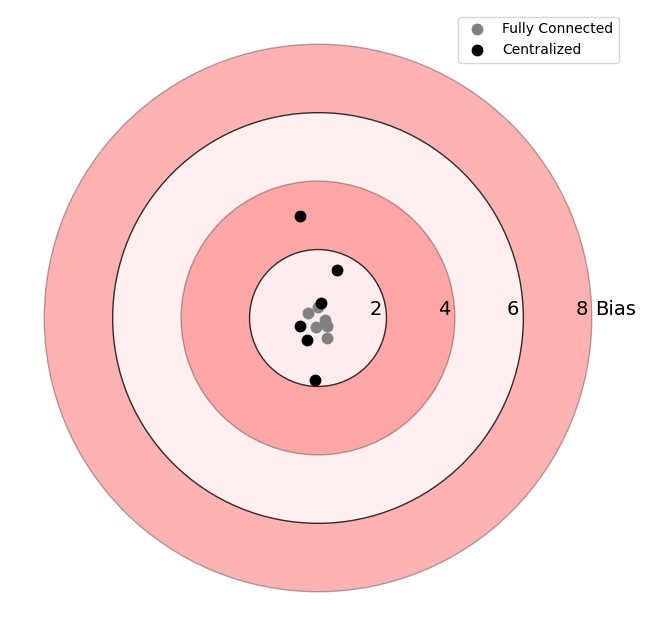

In [ ]:
import matplotlib.pyplot as plt
 
figure, axes = plt.subplots( 1 , 1, figsize=( 8 , 8 ))

a = plt.Circle(( 0.0 , 0.0 ), 8, alpha=0.3, facecolor='red',edgecolor='black',lw=1)
b = plt.Circle(( 0.0 , 0.0 ), 6, alpha=0.8, facecolor='white',edgecolor='black',lw=1)
c = plt.Circle(( 0.0 , 0.0 ), 4, alpha=0.3, facecolor='red',edgecolor='black',lw=1)
d = plt.Circle(( 0.0 , 0.0 ), 2, alpha=0.8, facecolor='white',edgecolor='black',lw=1)

axes.add_artist( a )
axes.add_artist( b )
axes.add_artist( c )
axes.add_artist( d )

#axes.annotate( '' , xy=( 8.2 , 0 ), xytext=( 0 , 0 ), arrowprops=dict(arrowstyle= '->' , color='black',lw=2))

# Add a label to the arrow
axes.text( 8.7 , 0.25 , 'Bias' , fontsize= 14 , color='black',ha='center',va='center')

axes.text( 1.7 , 0.25 , '2' , fontsize= 14 , color='black',ha='center',va='center')
axes.text( 3.7 , 0.25 , '4' , fontsize= 14 , color='black',ha='center',va='center')
axes.text( 5.7 , 0.25 , '6' , fontsize= 14 , color='black',ha='center',va='center')
axes.text( 7.7 , 0.25 , '8' , fontsize= 14 , color='black',ha='center',va='center')

axes.set_xlim( -9, 9 )
axes.set_ylim( -9, 9 )
axes.set_xticklabels( [] )
axes.set_yticklabels( [] )
axes.set_xticks( [] )
axes.set_yticks( [] )
axes.set_aspect( 1 )

points = np.random.rand(6)
rand_locs = np.random.rand(6)*6.28
xs = np.cos(rand_locs) * points
ys = np.sin(rand_locs) * points
plt.plot(xs,ys, 'o', color='gray', markersize=7.5, label = "Fully Connected")

points = np.random.rand(6) * 5
rand_locs = np.random.rand(6)*6.28
xs = np.cos(rand_locs) * points
ys = np.sin(rand_locs) * points
plt.plot(xs, ys, 'o', color='black', markersize=7.5, label = "Centralized")

axes.legend(loc='upper right', bbox_to_anchor=(1, 1))

# Turn off the border
axes.spines[ 'left' ].set_visible( False )
axes.spines[ 'right' ].set_visible( False )
axes.spines[ 'top' ].set_visible( False )
axes.spines[ 'bottom' ].set_visible( False )

# Add an arrow to the plot from 0 to 8


plt.show()


In [ ]:
np.array([1,2,3]) * np.array([1,2,3])

array([1, 4, 9])

In [ ]:
t

4.658575531228314

In [ ]:
# Generate random numbers using numpy
import numpy as np
import math
import random
np.random.seed(123)

# Generate 6 random numbers between 0 and 2pi
np.random.rand(6)*6.28

array([4.37382649, 1.79695502, 1.42462713, 3.46225675, 4.51826513,
       2.65710857])